In [ ]:
#connect to drive for getting dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/data.zip' #unzip the spectrograms file which contain the images of spectrograms

Streaming output truncated to the last 5000 lines.
  inflating: data/spectrograms/54-27-37--.png  
  inflating: data/spectrograms/54-28-38--.png  
  inflating: data/spectrograms/54-29-39--.png  
  inflating: data/spectrograms/54-30-40--.png  
  inflating: data/spectrograms/54-3-13-,r-.png  
  inflating: data/spectrograms/54-31-41--.png  
  inflating: data/spectrograms/54-32-42--.png  
  inflating: data/spectrograms/54-33-43--.png  
  inflating: data/spectrograms/54-34-44--.png  
  inflating: data/spectrograms/5-43-53--.png  
  inflating: data/spectrograms/54-35-45--.png  
  inflating: data/spectrograms/54-36-46--.png  
  inflating: data/spectrograms/54-37-47--.png  
  inflating: data/spectrograms/54-38-48--.png  
  inflating: data/spectrograms/54-39-49--.png  
  inflating: data/spectrograms/54-40-50--.png  
  inflating: data/spectrograms/54-4-14--.png  
  inflating: data/spectrograms/54-41-51--.png  
  inflating: data/spectrograms/54-42-52--.png  
  inflating: data/spectrograms/54-43-5

In [ ]:
!git clone https://github.com/saisriteja/paperworkteja.git

%tensorflow_version 1.x

from paperworkteja.codes import agumentations
from paperworkteja.codes.resnet_model import resnet_model,fbeta
from paperworkteja.codes.data_loading import get_data,train_test_val_split,get_csv_data

import pandas as pd

data = pd.read_csv('/content/data/data_analysis.csv')

pause = data.loc[data['speakingtot'] > 7.02]

pp = pd.read_csv('/content/data/labeling.csv')
names = [(i+'.png').replace('_',',') for i in pause['soundname'].tolist()]

clean_data = pp.loc[pp['filename'].isin(names)]

clean_data.to_csv('clean_data.csv',index = False)

fandr,f,r,perfect = get_csv_data('/content/clean_data.csv')

train_f,test_f,val_f = train_test_val_split(f)
train_r,test_r,val_r = train_test_val_split(r)
train_fandr,test_fandr,val_fandr = train_test_val_split(fandr)
train_perfect,test_perfect,val_perfect = train_test_val_split(perfect)

print('fandr'.ljust(20,'-'),train_fandr.shape,val_fandr.shape,test_fandr.shape)
print('fillers'.ljust(20,'-'),train_f.shape,val_r.shape,test_f.shape)
print('repetitions'.ljust(20,'-'),train_r.shape,val_r.shape,test_r.shape)
print('perfect'.ljust(20,'-'),train_perfect.shape,val_perfect.shape,test_perfect.shape)

w = 2048
root_path = '/content/data/spectrograms/'
img,labels = next(get_data(train_perfect,train_f,train_r,train_fandr,size=(w,256),root_path =root_path,agumentation_masking=True))

Cloning into 'paperworkteja'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 55 (delta 22), reused 17 (delta 7), pack-reused 0
Unpacking objects: 100% (55/55), done.
TensorFlow 1.x selected.


Using TensorFlow backend.


fandr--------------- (77, 3) (19, 3) (15, 3)
fillers------------- (718, 3) (110, 3) (222, 3)
repetitions--------- (390, 3) (110, 3) (125, 3)
perfect------------- (4684, 3) (1110, 3) (1458, 3)


In [ ]:
import matplotlib.pyplot as plt
# print(history.history.keys())
# summarize history for accuracy

def plot_history(history):

  plt.figure(figsize=(18,3))
  print(history.history.keys())
  plt.subplot(1,2,1)
  plt.plot(history.history['fbeta'])
  plt.plot(history.history['val_fbeta'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.show()

import numpy as np
import cv2
from tqdm import tqdm

def read_image(file_name):
    img = cv2.imread(file_name,0)
    size = (2048,256)
    img =cv2.resize(img,size)
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

def validation_testing(val_f,val_fandr,val_perfect,val_r,model_path,root_dir = '/content/data/spectrograms/'):
    files=[]
    labels = []
    results = []

    #enter the path of the model
    model.load_weights(model_path)

    for cat in tqdm([val_f,val_fandr,val_perfect,val_r], position = 0, leave = True):

      for i in np.array(cat):
        name,f,r = i
        img = read_image(root_dir+name)/255
        # print(img.shape)
        result = model.predict(img)
        results.extend(result)
        files.append(name)
        labels.append([f,r])
        # print(results,labels,files)
      #   break
      # break
    return (files,labels,results)



In [ ]:
import numpy as np
from keras.layers import MaxPooling2D,Bidirectional,LSTM,Reshape,BatchNormalization,Flatten,Dropout,Dense,Input,Conv2D, Activation, GlobalAveragePooling2D
from keras.layers import add
from keras.utils import plot_model
import copy
import warnings
warnings.filterwarnings('ignore')
import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, ResNet50
import keras
from keras import optimizers
from keras import backend
import keras
from keras import optimizers
from keras.layers import GaussianNoise
from keras.regularizers import l2,l1

def resnet_model(size = (256,2048,1)):
    ''' This model is build using keras module from the paper https://arxiv.org/pdf/1910.12590.pdf
    inputs are to be resized of 256,2048,1  and the no of classification items. I have fixed to binary as default
    output is the model
    '''
    input  = Input(shape = size)
    bnEps=2e-5
    bnMom=0.9


    c1 = Conv2D(64, (7,7), padding='same',strides=2, use_bias=False,kernel_initializer='glorot_uniform')(input)
    b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c1)

    c2 = conv1 = Conv2D(32, (3,3),strides=2, padding='same', use_bias=False,kernel_initializer='glorot_uniform')(input)
    b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c2)
    a2 = Activation('relu')(b2)

    c3 = conv1 = Conv2D(64, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a2)
    b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c3)
    a3 = Activation('relu')(b3)

    c4 = conv1 = Conv2D(64, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a3)
    b4 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c4)

    m1  = add([c1, b4])
    m1 = GaussianNoise(0.1)(m1)
    a4 = Activation('relu')(m1)


    #-----------------------------------------------layer 2----------------------------------------------------------------------------

    c1 = Conv2D(128, (3,3),strides=2, padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c1)

    c2 = conv1 = Conv2D(64, (3,3),strides=2, padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c2)
    a2 = Activation('relu')(b2)

    c3 = conv1 = Conv2D(128, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a2)
    b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c3)
    a3 = Activation('relu')(b3)

    c4 = conv1 = Conv2D(128, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a3)
    b4 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c4)

    m1  = add([c1, b4])
    m1 = GaussianNoise(0.1)(m1)

    a4 = Activation('relu')(m1)

    #----------------------------------------------layer 3------------------------------------------------------------------------------

    c1 = Conv2D(128, (3,3),strides = (1,2) ,padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c1)

    c2 = conv1 = Conv2D(128, (3,3),strides = (1,2), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c2)
    a2 = Activation('relu')(b2)

    c3 = conv1 = Conv2D(128, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a2)
    b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c3)
    a3 = Activation('relu')(b3)


    c4 = conv1 = Conv2D(128, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a3)
    b4 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c4)

    m1  = add([c1, b4])
    m1 = GaussianNoise(0.1)(m1)

    a4 = Activation('relu')(m1)

    #-------------------------------------------layer 4---------------------------------------------------------------------------------

    c1 = Conv2D(64, (3,3),strides = (2,2) ,padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c1)

    c2 = conv1 = Conv2D(128, (3,3),strides = (2,2), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c2)
    a2 = Activation('relu')(b2)

    c3 = conv1 = Conv2D(64, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a2)
    b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c3)
    a3 = Activation('relu')(b3)


    c4 = conv1 = Conv2D(64, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a3)
    b4 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c4)

    m1  = add([c1, b4])
    m1 = GaussianNoise(0.1)(m1)

    a4 = Activation('relu')(m1)

    #-------------------------------------------layer 5-----------------------------------------------------------------------------------
    c1 = Conv2D(32, (3,3),strides = (2,2) ,padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c1)

    c2 = conv1 = Conv2D(64, (3,3),strides = (2,2), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c2)
    a2 = Activation('relu')(b2)

    c3 = conv1 = Conv2D(64, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a2)
    b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c3)
    a3 = Activation('relu')(b3)


    c4 = conv1 = Conv2D(32, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a3)
    b4 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c4)

    m1  = add([c1, b4])
    m1 = GaussianNoise(0.1)(m1)
    a4 = Activation('relu')(m1)

    #-----------------------------------------layer 6-------------------------------------------------------------------------
    c1 = Conv2D(16, (3,3),strides = (2,2) ,padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b1 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c1)

    c2 = conv1 = Conv2D(32, (3,3),strides = (2,2), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a4)
    b2 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c2)
    a2 = Activation('relu')(b2)

    c3 = conv1 = Conv2D(32, (3,3), padding='same', use_bias=False,kernel_initializer='glorot_uniform')(a2)
    b3 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c3)
    a3 = Activation('relu')(b3)


    c4 = conv1 = Conv2D(16, (3,3), padding='same',use_bias=False,kernel_initializer='glorot_uniform')(a3)
    b4 = BatchNormalization(epsilon=bnEps, momentum=bnMom)(c4)

    m1  = add([c1, b4])
    m1 = GaussianNoise(0.1)(m1)
    a4 = Activation('relu')(m1)

    f = Flatten()(a4)
    # f = Reshape((int(8192/2), 1))(f)

    # #-----------------------------------------layer7---------------------------------------------------------------------------
    # bi1 = Bidirectional(LSTM(512, return_sequences=True))(f)
    bi1 = Dense(1024,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activity_regularizer=l1(0.0001))(f)
    d1  = Dropout(0.2)(bi1)
    n1 = GaussianNoise(0.1)(d1)
    # model.add()

    # bi2 = Bidirectional(LSTM(512))(d1)
    bi2 = Dense(512,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activity_regularizer=l1(0.0001))(n1)
    d2 = Dropout(0.4)(bi2)
    n1 = GaussianNoise(0.1)(d2)

    out = Dense(2,activation='sigmoid')(n1)

    # create model
    model = Model(inputs=input, outputs=out)
    return model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
56/56 [==============================] - 48s 857ms/step - loss: 22.6336 - fbeta: 0.3511 - val_loss: 20.9649 - val_fbeta: 0.2585

Epoch 00001: val_loss improved from inf to 20.96491, saving model to weight_reg-model.01-20.96.h5
Epoch 2/50
56/56 [==============================] - 33s 590ms/step - loss: 19.5281 - fbeta: 0.4031 - val_loss: 17.9528 - val_fbeta: 0.3164

Epoch 00002: val_loss improved from 20.96491 to 17.95281, saving model to weight_reg-model.02-17.95.h5
Epoch 3/50
56/56 [==============================] - 34s 607ms/step - loss: 16.2628 - fbeta: 0.4056 - val_loss: 14.5898 - val_fbeta: 0.3395

Epoch 00003: val_loss improved from 17.95281 to 14.58983, saving model to weight_reg-model.03-14.59.h5
Epoch 4/50
56/56 [==============================] - 33s 595ms/step - loss: 12.9844 - fbeta: 0.4282 -

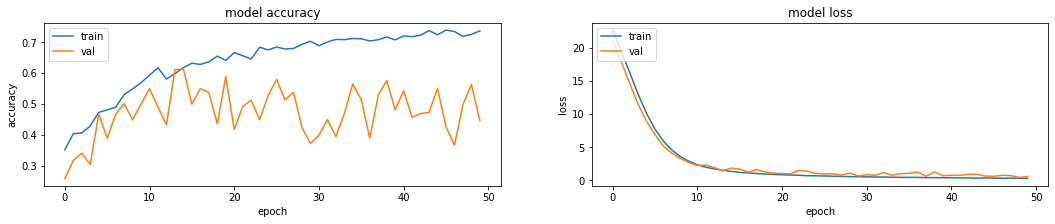

In [ ]:
model = resnet_model()
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=0.0001),metrics=[fbeta])

my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10, monitor="val_loss",min_delta=0.0001,verbose = 2),
    keras.callbacks.ModelCheckpoint(filepath='weight_reg-model.{epoch:02d}-{val_loss:.2f}.h5',verbose = 1,save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=1,factor = 0.99,verbose = 2)
]


batch_size = 32

w = 2048

history = model.fit_generator(get_data(train_perfect,train_f,train_r,train_fandr,size=(w,256),root_path =root_path,agumentation_masking=False),
                              steps_per_epoch=int((72+821+410+500)/batch_size),               #sum of all the train samples can be checked from above shapes
                              epochs=50,
                              validation_data=get_data(val_perfect,val_f,val_r,val_fandr,size=(w,256),root_path =root_path),
                              validation_steps=int((19+99+99+100)/batch_size),              #sum of all the val samples can be checked from above shapes
                              callbacks = my_callbacks)

plot_history(history)

Epoch 1/50
28/28 [==============================] - 17s 603ms/step - loss: 0.3645 - fbeta: 0.7019 - val_loss: 1.1284 - val_fbeta: 0.5069

Epoch 00001: val_loss did not improve from 0.41856
Epoch 2/50
28/28 [==============================] - 17s 595ms/step - loss: 0.3575 - fbeta: 0.7118 - val_loss: 1.0194 - val_fbeta: 0.3438

Epoch 00002: val_loss did not improve from 0.41856
Epoch 3/50
28/28 [==============================] - 17s 596ms/step - loss: 0.3234 - fbeta: 0.6937 - val_loss: 0.9268 - val_fbeta: 0.3993

Epoch 00003: val_loss did not improve from 0.41856
Epoch 4/50
28/28 [==============================] - 17s 596ms/step - loss: 0.3408 - fbeta: 0.6964 - val_loss: 0.7049 - val_fbeta: 0.4896

Epoch 00004: val_loss did not improve from 0.41856
Epoch 5/50
28/28 [==============================] - 17s 595ms/step - loss: 0.3122 - fbeta: 0.7019 - val_loss: 1.1291 - val_fbeta: 0.5156

Epoch 00005: val_loss did not improve from 0.41856

Epoch 00005: ReduceLROnPlateau reducing learning rate 

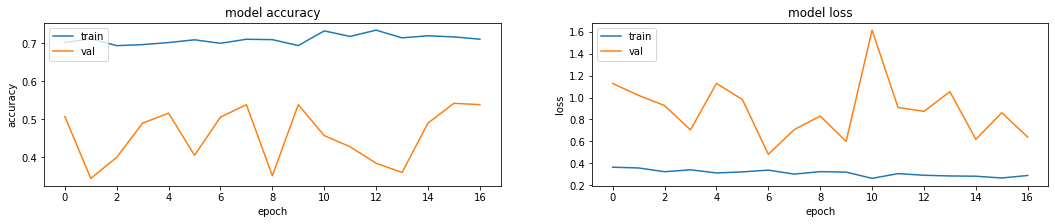

In [ ]:
batch_size = 64

w = 2048

history = model.fit_generator(get_data(train_perfect,train_f,train_r,train_fandr,size=(w,256),root_path =root_path,agumentation_masking=True),
                              steps_per_epoch=int((72+821+410+500)/batch_size),               #sum of all the train samples can be checked from above shapes
                              epochs=50,
                              validation_data=get_data(val_perfect,val_f,val_r,val_fandr,size=(w,256),root_path =root_path),
                              validation_steps=int((19+99+99+100)/batch_size),              #sum of all the val samples can be checked from above shapes
                              callbacks = my_callbacks)

plot_history(history)

Epoch 1/50
14/14 [==============================] - 9s 608ms/step - loss: 0.2804 - fbeta: 0.7356 - val_loss: 0.9724 - val_fbeta: 0.3889
Epoch 2/50
14/14 [==============================] - 8s 595ms/step - loss: 0.2643 - fbeta: 0.7321 - val_loss: 1.3181 - val_fbeta: 0.2569

Epoch 00002: ReduceLROnPlateau reducing learning rate to 6.689715184620581e-05.
Epoch 3/50
14/14 [==============================] - 8s 595ms/step - loss: 0.2801 - fbeta: 0.7396 - val_loss: 0.9891 - val_fbeta: 0.4792

Epoch 00003: ReduceLROnPlateau reducing learning rate to 6.622818364121486e-05.
Epoch 4/50
14/14 [==============================] - 8s 594ms/step - loss: 0.2663 - fbeta: 0.7143 - val_loss: 0.3023 - val_fbeta: 0.6042
Epoch 5/50
14/14 [==============================] - 8s 594ms/step - loss: 0.2581 - fbeta: 0.7232 - val_loss: 1.0569 - val_fbeta: 0.5417

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.55659000040032e-05.
Epoch 6/50
14/14 [==============================] - 8s 594ms/step - loss: 0.23

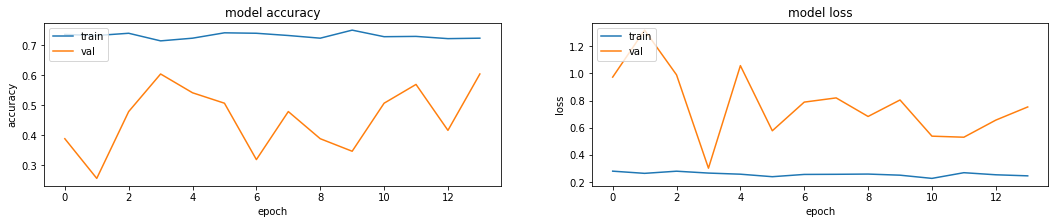

In [ ]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10, monitor="val_loss",min_delta=0.0001,verbose = 2),
    keras.callbacks.ModelCheckpoint(filepath='weight_reg-model.{epoch:02d}-{val_loss:.2f}.h5',verbose = 0,save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=1,factor = 0.99,verbose = 2)
]


batch_size = 128

w = 2048

history = model.fit_generator(get_data(train_perfect,train_f,train_r,train_fandr,size=(w,256),root_path =root_path,agumentation_masking=True),
                              steps_per_epoch=int((72+821+410+500)/batch_size),               #sum of all the train samples can be checked from above shapes
                              epochs=50,
                              validation_data=get_data(val_perfect,val_f,val_r,val_fandr,size=(w,256),root_path =root_path),
                              validation_steps=int((19+99+99+100)/batch_size),              #sum of all the val samples can be checked from above shapes
                              callbacks = my_callbacks)

plot_history(history)

In [ ]:
model_path = '/content/weight_reg-model.04-0.30.h5'

files,labels,results = validation_testing(test_f,test_fandr,test_perfect,test_r,model_path)

labels,results = np.array(labels),np.array(results)

predictions = []

for i in range(10,100,10):
  print('\n')
  i = i/100
  predicted = np.where(results >= i, results, 0)
  predicted = np.where(results < i, predicted, 1) 

  predictions.append(predicted)

  from sklearn.metrics import fbeta_score
  print('for threhold',i,'fscore is',round(fbeta_score(labels, predicted, average='macro', beta=2)*100,3))

100%|██████████| 4/4 [01:06<00:00, 16.50s/it]




for threhold 0.1 fscore is 59.918


for threhold 0.2 fscore is 63.694


for threhold 0.3 fscore is 64.0


for threhold 0.4 fscore is 64.44


for threhold 0.5 fscore is 64.603


for threhold 0.6 fscore is 62.939


for threhold 0.7 fscore is 62.5


for threhold 0.8 fscore is 58.41


for threhold 0.9 fscore is 51.329


In [ ]:
rough_variable = predicted

In [ ]:
i =0.7
predicted = np.where(results >= i, results, 0)
predicted = np.where(results < i, predicted, 1)

fillers_pred = predicted[:,0]
repeitions_pred = predicted[:,1]

fillers_org = labels[:,0]
repetitions_org = labels[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(fillers_org , fillers_pred)

array([[1496,   87],
       [  81,  156]])

In [ ]:
confusion_matrix(repetitions_org , repeitions_pred)

array([[1559,  121],
       [  48,   92]])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(fillers_org , fillers_pred)

array([[1322,  228],
       [  46,  195]])

In [ ]:
confusion_matrix(repetitions_org , repeitions_pred)

array([[1561,   90],
       [  55,   85]])

#cam grad

In [ ]:
# import numpy as np
# import scipy as sp
# import matplotlib.pyplot as plt

# # import Keras's functional api
# from keras.models import Model

# model = resnet_model()

# # get the weights from the last layer
# gap_weights = model.layers[-1].get_weights()[0]

# # create a new model to output the feature maps and the predicted labels
# cam_model = Model(inputs=model.input, 
#                     outputs=(model.layers[-9].output, model.layers[-1].output)) 

# # # make the prediction for a set of test images
# # features, results = cam_model.predict(test_img)

In [ ]:
imgs,labels = next(get_data(train_perfect,train_f,train_r,train_fandr,size=(w,256),root_path =root_path,agumentation_masking=False))

In [ ]:
labels

array([[0, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [1, 1]])

In [ ]:
model_path = '/content/weight_reg-model.04-0.30.h5'

files,labels,results = validation_testing(test_f,test_fandr,test_perfect,test_r,model_path)


100%|██████████| 4/4 [01:04<00:00, 16.16s/it]


In [ ]:
def grad_cam(img,label):
    print(img)

    img = cv2.imread(img,0)
    img = cv2.resize(img,(2048,256))
    print(img.shape)

    img = np.expand_dims(img,0)
    img = np.expand_dims(img,-1)
    preds = model.predict(img)
    output = model.output[:, label]

    last_conv_layer = model.get_layer('activation_18')

    grads = K.gradients(output, last_conv_layer.output)[0]

    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])


    pooled_grads_value, conv_layer_output_value = iterate([img])

    for i in range(16):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    # plt.matshow(heatmap)

    heatmap = np.expand_dims(cv2.resize(heatmap, (2048,256)),axis = -1)
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    superimposed_img = (heatmap * 0.5)*(1/255) + np.squeeze(img,axis = 0)


    print(heatmap.shape,superimposed_img.shape)

    return (np.squeeze(np.squeeze(img,axis = 0),axis = -1),heatmap,np.squeeze(superimposed_img))

/content/data/spectrograms/2020-08-26140103575314-7-17--.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


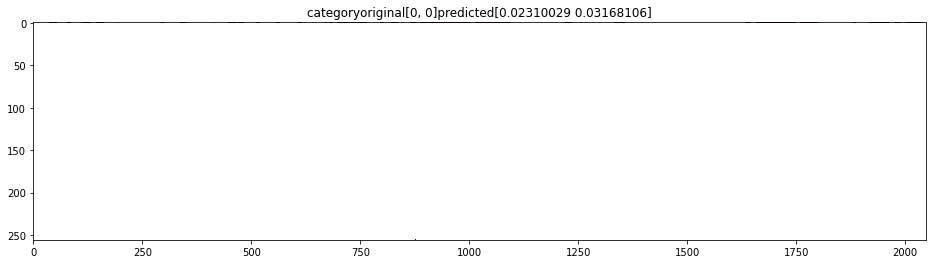

/content/data/spectrograms/12-130-140--.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


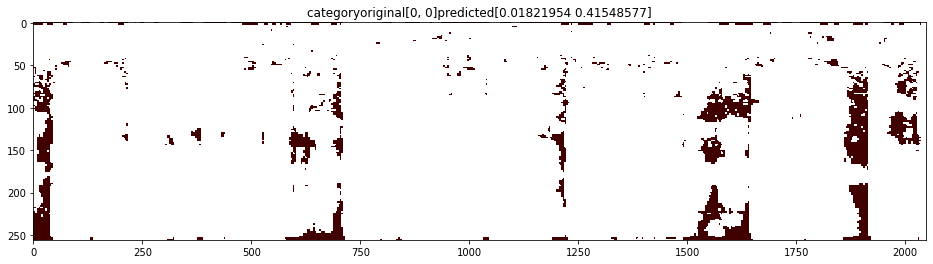

/content/data/spectrograms/2020-08-25150030969189-45-55-,f-.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


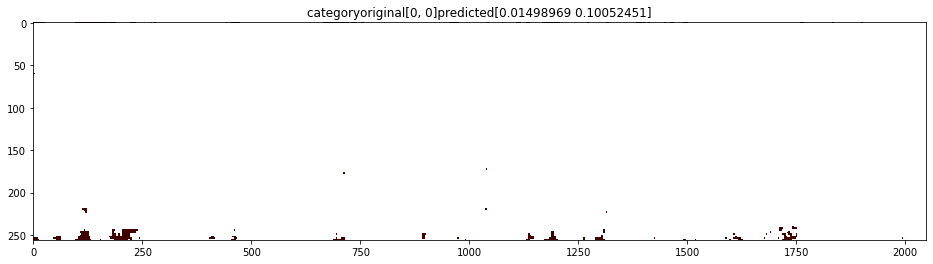

/content/data/spectrograms/73-12-22-,r,r-.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


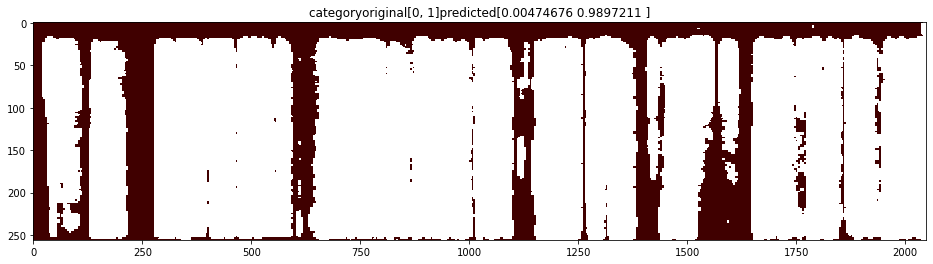

/content/data/spectrograms/66-49-59--.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


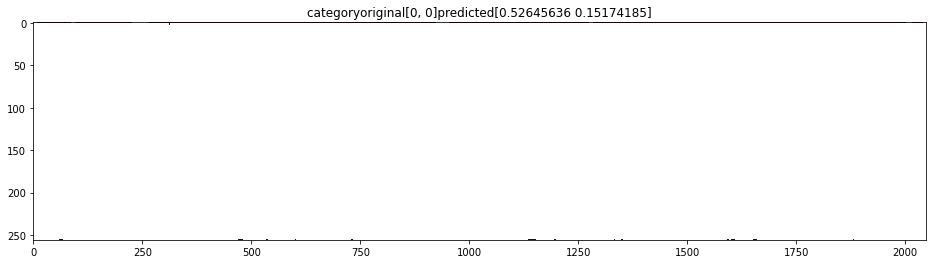

/content/data/spectrograms/35-25-35--.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


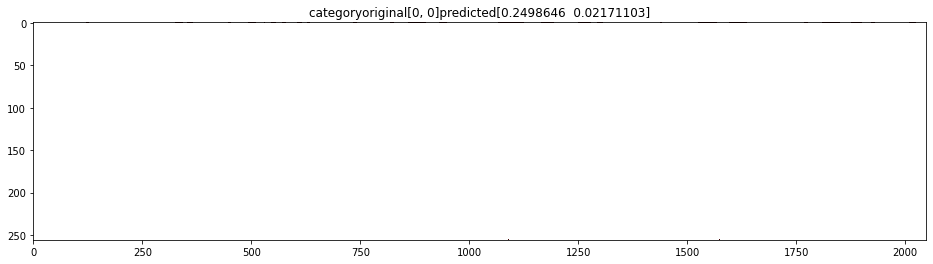

/content/data/spectrograms/75-114-124--.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


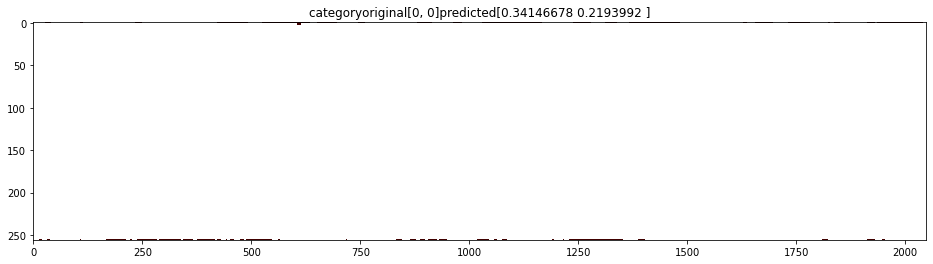

/content/data/spectrograms/87-70-80-,f-.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


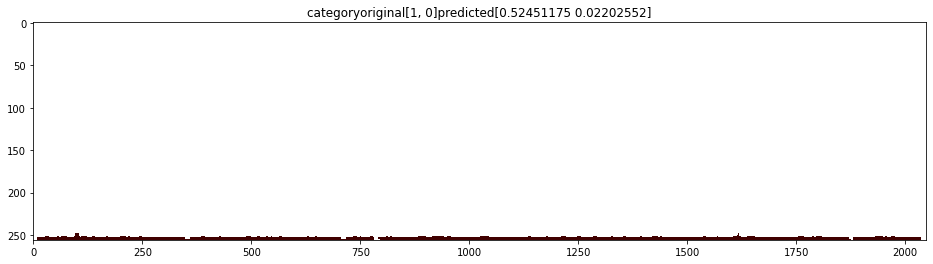

/content/data/spectrograms/12-107-117--.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


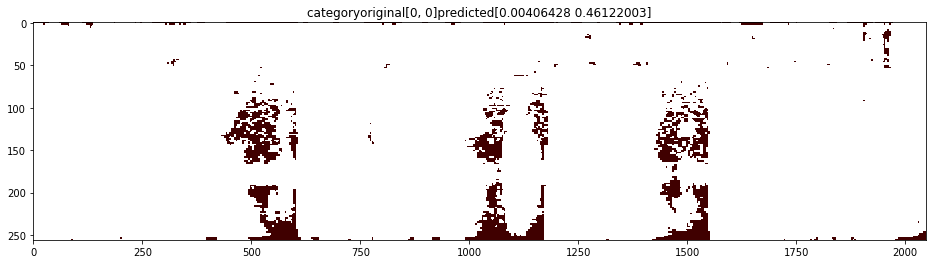

/content/data/spectrograms/9-20-30--.png
(256, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 2048, 3) (256, 2048, 3)
------------------------------------------------------------------------------------------------------------------------


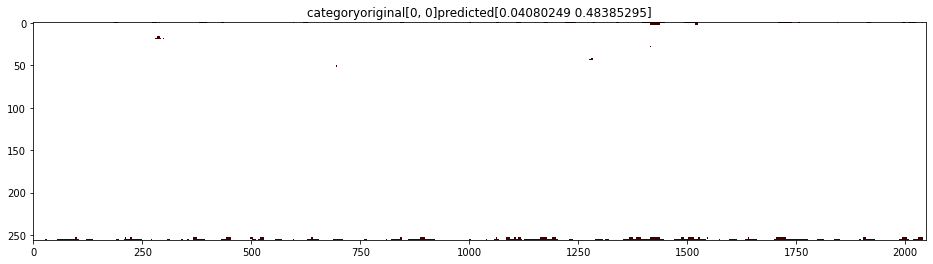

In [ ]:
predss = predictions[-1]

img_path = '/content/data/spectrograms/'


for i in random.sample(range(0,1820),10):
    i1,i2,i3 = grad_cam(img_path+files[i],0)
    print('-'.center(120,'-'))

      # # plt.figure(figsize=(20,12))
    f, axs = plt.subplots(1,1,figsize=(16,4),squeeze=False)

    # # axs.subplot(3,1,1)
    # axs[0][0].imshow(i1, interpolation='nearest', aspect='auto')

    # # axs.subplot(3,1,2)
    # axs[1][0].matshow(i2, aspect='auto')

    # axs.subplot(3,1,3)
    # plt.figure(figsize=(18,3))
    axs[0][0].imshow(i3, interpolation='nearest', aspect='auto')
    axs[0][0].set_title('category'+'original'+str(labels[i])+'predicted'+str(results[i]))

    plt.show()
    # break


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 2048, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 1024, 32 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 1024, 32 128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 1024, 32 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________